# Create folders for input and and processed files

In [1]:
import os

# Create a directory to store the text files
if not os.path.exists("text/"):
        os.mkdir("text/")
        # Create .txt file
        with open("text/file.txt", 'w') as file:
            file.write("Insert your content here.")

# Create a directory to store the csv files
if not os.path.exists("processed"):
        os.mkdir("processed")

# Building an embeddings index

In [2]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [3]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + "/"):

    # Open the file and read the text
    with open("text/" + "/" + file, "r", encoding="UTF-8") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

,fname,text
0,,". So Penelope, thanks for joining us today. Yo..."


<Axes: >

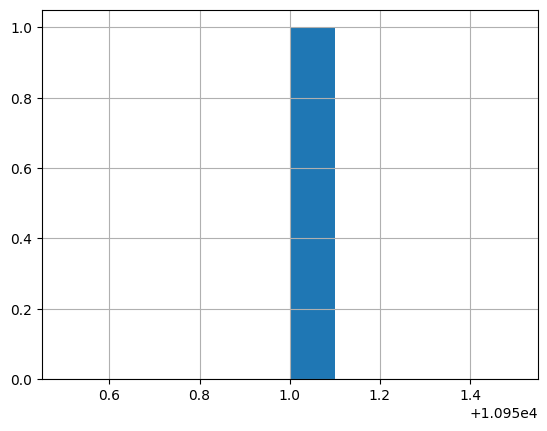

In [4]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [5]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<Axes: >

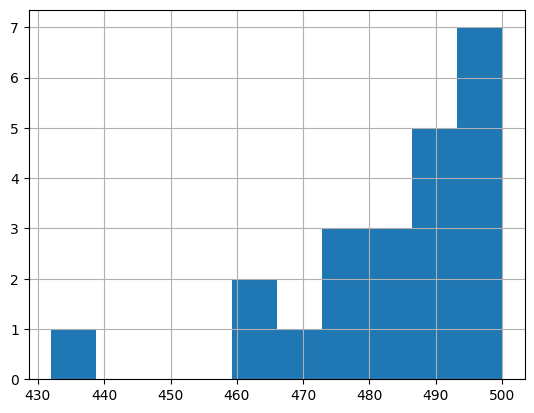

In [6]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [7]:
import openai

df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])

df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,". So Penelope, thanks for joining us today. Yo...",500,"[-0.011237400583922863, 0.0074318512342870235,..."
1,and you’re looking at the black line and you’r...,497,"[-0.008365004323422909, 0.006475279573351145, ..."
2,"I mean, he would make these putts almost 99 pe...",474,"[-0.003320524701848626, -0.013655866496264935,..."
3,"So what I mean by that is like, let’s say you’...",466,"[-0.02363983541727066, -0.024598577991127968, ..."
4,But going back to your energy that it took for...,461,"[-0.010190695524215698, -0.013487685471773148,..."


# Building a question answer system with your embeddings

In [8]:
import numpy as np
from openai.embeddings_utils import distances_from_embeddings

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,". So Penelope, thanks for joining us today. Yo...",500,"[-0.011237400583922863, 0.0074318512342870235,..."
1,and you’re looking at the black line and you’r...,497,"[-0.008365004323422909, 0.006475279573351145, ..."
2,"I mean, he would make these putts almost 99 pe...",474,"[-0.003320524701848626, -0.013655866496264935,..."
3,"So what I mean by that is like, let’s say you’...",466,"[-0.02363983541727066, -0.024598577991127968, ..."
4,But going back to your energy that it took for...,461,"[-0.010190695524215698, -0.013487685471773148,..."


In [9]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [10]:
def answer_question(
    df,
    model="gpt-3.5-turbo",
    question="What is this file about?",
    max_len=1800,
    size="ada",
    debug=False,
    # max_tokens=150,
    max_tokens=1024,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        messages = [
            {"role": "system", "content": f"Context: {context}"},
            {"role": "user", "content": question},
        ]
        
        response = openai.ChatCompletion.create(
            model=model,
            messages=messages,
            temperature=0,
            max_tokens=max_tokens,
            stop=stop_sequence,
        )
        return response["choices"][0]["message"]["content"].strip()
    except Exception as e:
        print(e)
        return ""

In [11]:
# answer_question(df, question="Make a summary of this post")

# Save output of answer_question to a txt file
with open('processed/answer.txt', 'w') as f:
    f.write(answer_question(df, question="What is this post about?"))